In [2]:
import json
import pandas as pd

In [3]:
import os
os.getcwd()

'/Users/naziheffendi/Documents/EDHEC/NLP/Indeed_Scraping-main'

# Importing Data

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
# Business Analyst -> BA
# Data Analyst -> DA
# Data Engineer -> DE
# Data Scientist -> DS

In [4]:
json_file_path_ba = "../Indeed_Scraping-main/searches_results/saved_jobs_business analyst_.json"
json_file_path_da = "../Indeed_Scraping-main/searches_results/saved_jobs_data analyst_.json"
json_file_path_de = "../Indeed_Scraping-main/searches_results/saved_jobs_data engineer_.json"
json_file_path_ds = "../Indeed_Scraping-main/searches_results/saved_jobs_data scientist_.json"

In [5]:
with open(json_file_path_ba, encoding='utf-8') as f:
    data_ba = json.load(f)
    
with open(json_file_path_da, encoding='utf-8') as f:
    data_da = json.load(f)

with open(json_file_path_de, encoding='utf-8') as f:
    data_de = json.load(f)

with open(json_file_path_ds, encoding='utf-8') as f:
    data_ds = json.load(f)

In [6]:
def extract_info(jobs_dict: dict, key: str):
    return [job[key] for _, job in jobs_dict.items()]

## Extracting the description for each job into a list

In [7]:
descriptions_list_ba = extract_info(data_ba, "description")
descriptions_list_da = extract_info(data_da, "description")
descriptions_list_de = extract_info(data_de, "description")
descriptions_list_ds = extract_info(data_ds, "description")

In [8]:
## Setup ##

# imports

# built-in Python libraries
# -------------------------

# counting and data management
import collections
# operating system utils
import os
# regular expressions
import re
# additional string functions
import string
# system utilities
import sys
# request() will be used to load web content
import urllib.request

import nltk.corpus

# 3rd party libraries
# -------------------

# Natural Language Toolkit (https://www.nltk.org/)
import nltk

# download punctuation related NLTK functions
# (needed for sent_tokenize())
nltk.download('punkt')
# download NLKT part-of-speech tagger
# (needed for pos_tag())
nltk.download('averaged_perceptron_tagger')
# download wordnet
# (needed for lemmatization)
nltk.download('wordnet')
# download stopword lists
# (needed for stopword removal)
nltk.download('stopwords')
# dictionary of English words
nltk.download('words')

# numpy: matrix library for Python
import numpy as np

# scipy: scientific operations
# works with numpy objects
import scipy

# matplotlib (and pyplot) for visualizations
import matplotlib
import matplotlib.pyplot as plt

# sklearn for basic machine learning operations
import sklearn
import sklearn.manifold
import sklearn.cluster

# worldcloud tool
#!pip install wordcloud
from wordcloud import WordCloud

# for checking object memory usage
!pip install pympler
from pympler import asizeof

#!pip install spacy
import spacy

# Downloading data
# ----------------
if not os.path.exists("aclImdb"):
    !wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    !tar -xzf aclImdb_v1.tar.gz

print()
print("Done with setup!")
print("If you'd like, you can click the (X) button to the left to clear this output.")

[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 8] nodename nor servname provided, or not
[nltk_data]     known>
[nltk_data] Error loading wordnet: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>
[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>
[nltk_data] Error loading words: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>


zsh:1: command not found: wget
tar: Error opening archive: Failed to open 'aclImdb_v1.tar.gz'

Done with setup!
If you'd like, you can click the (X) button to the left to clear this output.


In [9]:
text_ba = " ".join(descriptions_list_ba)
text_da = " ".join(descriptions_list_da)
text_de = " ".join(descriptions_list_de)
text_ds = " ".join(descriptions_list_ds)


In [10]:
# Converting text to a dictionary mapping strings to a FreqDist object
# containing the frequences of the lemmas in the text.
# All stopwords will be removed.
# Inputs:
#   text: a string as input,  containing multiple sentences.

def text_to_lemma_frequencies(text, remove_stop_words=True):
    text = re.sub("[()]","", text)
    text.replace(".", "").replace(",", "").replace("''", "").replace("``", "").replace("'", "").strip(string.punctuation)
    
    # split document into sentences
    sentences = nltk.sent_tokenize(text)
    
    # create a place to store (word, pos_tag) tuples
    words_and_pos_tags = []
    
    # get all words and pos tags
    for sentence in sentences:
        words_and_pos_tags += nltk.pos_tag(nltk.word_tokenize(sentence))
        
    # load the lemmatizer
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    # lemmatize the words
    lemmas = [lemmatizer.lemmatize(word,lookup_pos(pos)) for \
              (word,pos) in words_and_pos_tags]
    
    # convert to lowercase
    lowercase_lemmas = [lemma.lower() for lemma in lemmas]
    
    # load the stopword list for English
    stop_words = set([])
    if remove_stop_words:
        stop_words = set(nltk.corpus.stopwords.words('english'))
    
    # add punctuation to the set of things to remove
    all_removal_tokens = stop_words | set(string.punctuation)
    
    # bonus: also add some custom double-quote tokens to this set
    all_removal_tokens |= set(["''","``"])
    
    # only get lemmas that aren't in these lists
    content_lemmas = [lemma for lemma in lowercase_lemmas \
                      if lemma not in all_removal_tokens]
    
    # return the frequency distribution object
    return nltk.probability.FreqDist(content_lemmas)
    
# Lemmatization -- redefining this here to make
# code block more self-contained
def lookup_pos(pos):
    pos_first_char = pos[0].lower()
    if pos_first_char in 'nv':
        return pos_first_char
    else:
        return 'n'
    

In [11]:
# Code to create the Word Cloud 
def draw_wordcloud(freq_dist, colormap):
    
    #TODO add a few corpus specific checks here to make sure people have done casing, lemmatization, punct removal
    uniq_count = len(freq_dist.keys())
    print("Building a word cloud with",uniq_count,"unique words...")
    wc = WordCloud(colormap=colormap, width=1500, 
                   height=1000).generate_from_frequencies(freq_dist)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
print("draw_wordcloud() function is ready to use.")

draw_wordcloud() function is ready to use.


In [12]:
# Get the word frequency distribution
freq_dist_ba = text_to_lemma_frequencies(text_ba, remove_stop_words = True)
freq_dist_da = text_to_lemma_frequencies(text_da, remove_stop_words = True)
freq_dist_de = text_to_lemma_frequencies(text_de, remove_stop_words = True)
freq_dist_ds = text_to_lemma_frequencies(text_ds, remove_stop_words = True)

# Use default colormap
colormap = None


Building a word cloud with 8676 unique words...


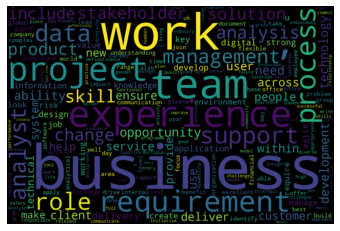

In [13]:
# Call the function to draw the word cloud for Business Analyst
draw_wordcloud(freq_dist_ba, colormap)

Building a word cloud with 9055 unique words...


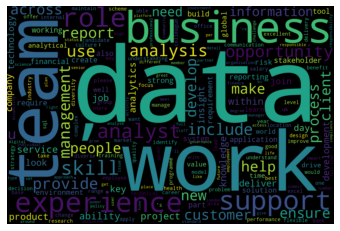

In [14]:
# Call the function to draw the word cloud for Data Analyst
draw_wordcloud(freq_dist_da, colormap)

Building a word cloud with 4840 unique words...


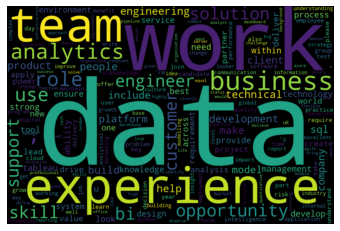

In [15]:
# Call the function to draw the word cloud for Data Engineer
draw_wordcloud(freq_dist_de, colormap)

Building a word cloud with 9352 unique words...


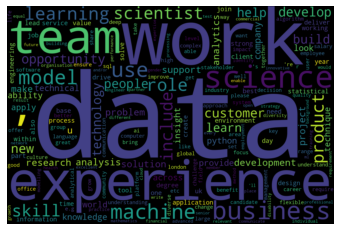

In [16]:
# Call the function to draw the word cloud for Data Scientist
draw_wordcloud(freq_dist_ds, colormap)

## Frequency Graphs

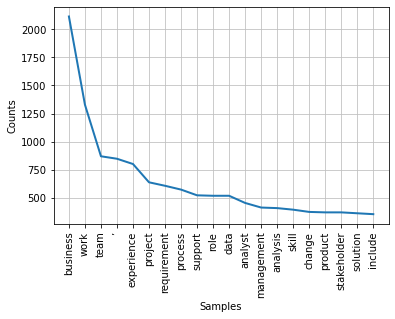

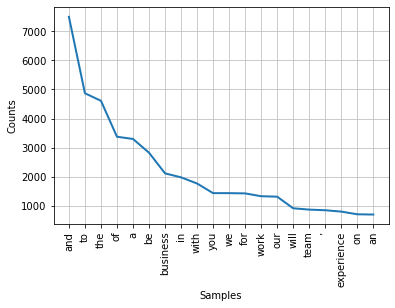

In [17]:
# Checking the frequency distribution of the top 20 words for Business Analyst
top_n_words = 20
freq_dist_ba.plot(top_n_words, cumulative=False)
plt.show()

# Checking the frequency distribution of the top 20 words without removing stop words
freq_dist_wostop_ba = text_to_lemma_frequencies(text_ba, remove_stop_words=False)
top_n_words = 20
freq_dist_wostop_ba.plot(top_n_words, cumulative=False)
plt.show()


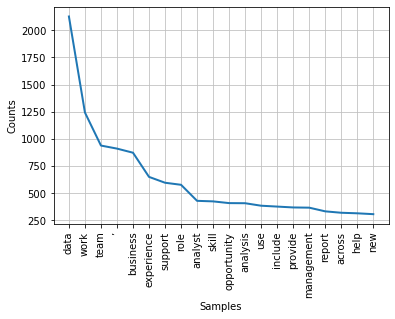

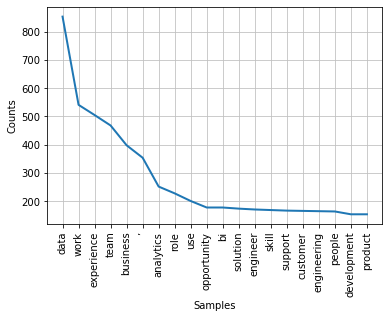

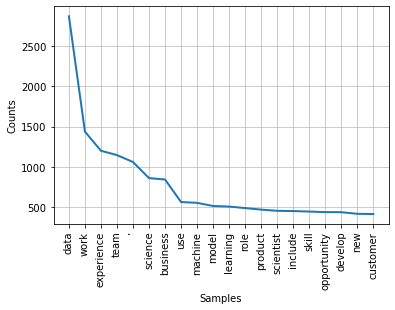

In [18]:
# Checking the frequency distribution of the top 20 words for Data Analyst
top_n_words = 20
freq_dist_da.plot(top_n_words, cumulative=False)
plt.show()

# Checking the frequency distribution of the top 20 words for Data Engineer
top_n_words = 20
freq_dist_de.plot(top_n_words, cumulative=False)
plt.show()

# Checking the frequency distribution of the top 20 words for Data Science
top_n_words = 20
freq_dist_ds.plot(top_n_words, cumulative=False)
plt.show()

# Corpus Matrices
## Creating Bag of Words with sklearn for every position

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [20]:
# Building the corpus for every position
wordnet=WordNetLemmatizer()
sentences_ba = nltk.sent_tokenize(text_ba)
corpus_ba = []
for i in range(len(sentences_ba)):
    review = re.sub('[^a-zA-Z]', ' ', sentences_ba[i])
    review = review.lower()
    review = review.split()
    review = [wordnet.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus_ba.append(review)
    

sentences_da = nltk.sent_tokenize(text_da)
corpus_da = []
for i in range(len(sentences_da)):
    review = re.sub('[^a-zA-Z]', ' ', sentences_da[i])
    review = review.lower()
    review = review.split()
    review = [wordnet.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus_da.append(review)
    

sentences_de = nltk.sent_tokenize(text_de)
corpus_de = []
for i in range(len(sentences_de)):
    review = re.sub('[^a-zA-Z]', ' ', sentences_de[i])
    review = review.lower()
    review = review.split()
    review = [wordnet.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus_de.append(review)
    

sentences_ds = nltk.sent_tokenize(text_ds)
corpus_ds = []
for i in range(len(sentences_ds)):
    review = re.sub('[^a-zA-Z]', ' ', sentences_ds[i])
    review = review.lower()
    review = review.split()
    review = [wordnet.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus_ds.append(review)

## Creating Bag of Words

In [28]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

cv = CountVectorizer()
bow_ba = cv.fit_transform(corpus_ba)
feature_names_ba = cv.get_feature_names()
dense_ba = bow_ba.todense()
lst_ba= dense_ba.tolist()
df_ba = pd.DataFrame(lst_ba, columns=feature_names_ba) # df.T.sum(axis=1)


bow_da = cv.fit_transform(corpus_da)
feature_names_da = cv.get_feature_names()
dense_da = bow_da.todense()
lst_da= dense_da.tolist()
df_da = pd.DataFrame(lst_da, columns=feature_names_da)

bow_de = cv.fit_transform(corpus_de)
feature_names_de = cv.get_feature_names()
dense_de = bow_de.todense()
lst_de= dense_de.tolist()
df_de = pd.DataFrame(lst_de, columns=feature_names_de)

bow_ds = cv.fit_transform(corpus_ds)
feature_names_ds = cv.get_feature_names()
dense_ds = bow_ds.todense()
lst_ds= dense_ds.tolist()
df_ds = pd.DataFrame(lst_ds, columns=feature_names_ds)



## Drawing the word cloud with Bag of Words

(-0.5, 399.5, 199.5, -0.5)

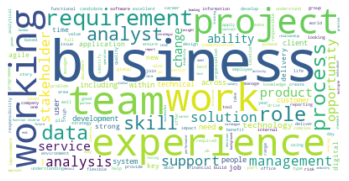

In [23]:
# Business Analyst
wc_ba = WordCloud(background_color="white").generate_from_frequencies(df_ba.T.sum(axis=1))
plt.imshow(wc_ba, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

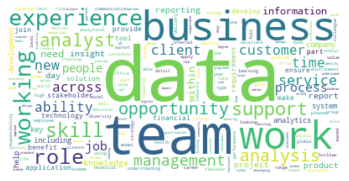

In [24]:
# Data Analyst
wc_da = WordCloud(background_color="white").generate_from_frequencies(df_da.T.sum(axis=1))
plt.imshow(wc_da, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

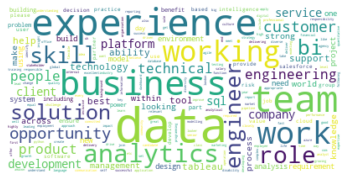

In [25]:
# Data Engineer
wc_de = WordCloud(background_color="white").generate_from_frequencies(df_de.T.sum(axis=1))
plt.imshow(wc_de, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

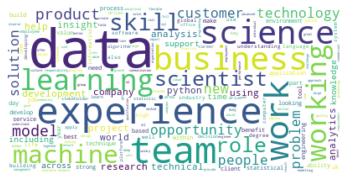

In [26]:
# Data Science
wc_ds = WordCloud(background_color="white").generate_from_frequencies(df_ds.T.sum(axis=1))
plt.imshow(wc_ds, interpolation='bilinear')
plt.axis("off")

## We see that the word "business" is the most used word in this corpus but it is a word that creates "noise" since we are searching for a business analyst.
## This is the similar case for all the data positions. Data is the mos frequesnt word but that is going to be obvious and does not provide us any insight
## We will use TF-IDF to reduce the importance of the word "business" & "data"

# TF-IDF Using SKLEARN

(-0.5, 399.5, 199.5, -0.5)

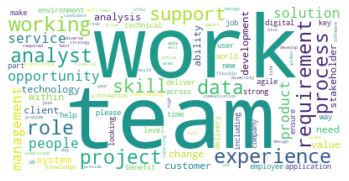

In [29]:
warnings.filterwarnings("ignore", category=FutureWarning)

# We will use to max_df feature to remove words that have come more 'x' percent of the time
# TF-IDF for Business Analyst position
tv_ba = TfidfVectorizer(max_df = 0.2)
tfidf_ba = tv_ba.fit_transform(corpus_ba)
feature_names_ba = tv_ba.get_feature_names()
dense_ba = tfidf_ba.todense()
lst_ba = dense_ba.tolist()
df_ba = pd.DataFrame(lst_ba, columns=feature_names_ba)

# Drawing the Word Cloud with TF-IDF

wc = WordCloud(background_color="white", max_words = 100).generate_from_frequencies(df_ba.T.sum(axis=1))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")


(-0.5, 399.5, 199.5, -0.5)

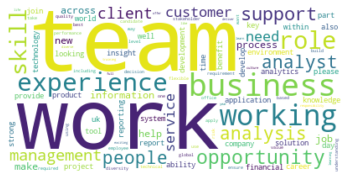

In [32]:
# TF-IDF for Data Analyst position

warnings.filterwarnings("ignore", category=FutureWarning)

tv_da = TfidfVectorizer(max_df = 0.2)
tfidf_da = tv_da.fit_transform(corpus_da)
feature_names_da = tv_da.get_feature_names()
dense_da = tfidf_da.todense()
lst_da = dense_da.tolist()
df_da = pd.DataFrame(lst_da, columns=feature_names_da)

# Drawing the Word Cloud with TF-IDF

wc = WordCloud(background_color="white", max_words = 100).generate_from_frequencies(df_da.T.sum(axis=1))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")


(-0.5, 399.5, 199.5, -0.5)

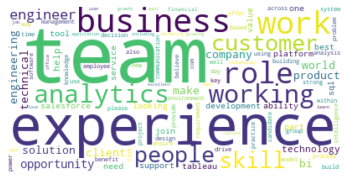

In [33]:
# TF-IDF for Data Engineer position

warnings.filterwarnings("ignore", category=FutureWarning)

tv_de= TfidfVectorizer(max_df = 0.2)
tfidf_de = tv_de.fit_transform(corpus_de)
feature_names_de = tv_de.get_feature_names()
dense_de = tfidf_de.todense()
lst_de = dense_de.tolist()
df_de = pd.DataFrame(lst_de, columns=feature_names_de)

# Drawing the Word Cloud with TF-IDF

wc = WordCloud(background_color="white", max_words = 100).generate_from_frequencies(df_de.T.sum(axis=1))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

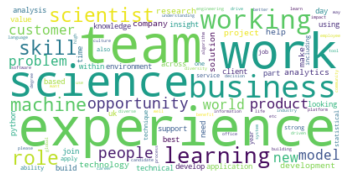

In [37]:
# TF-IDF for Data Scientist position

warnings.filterwarnings("ignore", category=FutureWarning)

tv_ds= TfidfVectorizer(max_df = 0.2)
tfidf_ds = tv_ds.fit_transform(corpus_ds)
feature_names_ds = tv_ds.get_feature_names()
dense_ds = tfidf_ds.todense()
lst_ds = dense_ds.tolist()
df_ds = pd.DataFrame(lst_ds, columns=feature_names_ds)

# Drawing the Word Cloud with TF-IDF

wc = WordCloud(background_color="white", max_words = 100).generate_from_frequencies(df_ds.T.sum(axis=1))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

## USING GENSIM FOR LDA AND TOPIC MODELLING

In [39]:
# !pip install -U gensim

# Gensim for topic modeling
import gensim

# for LDA visualization
# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
import numpy as np
import json
import glob


import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [40]:
# Functions for pre-processing data 
def docs2matrix(document_list):
    
    # use the vocab2index idea from before
    vocab2index = {}
    
    # load the stopword list for English
    stop_words = set(nltk.corpus.stopwords.words('english'))
    stop_words |= set(['from', 'subject', 're', 'edu', 'use'])
    
    # add punctuation to the set of things to remove
    all_removal_tokens = stop_words | set(string.punctuation)
    
    # bonus: also add some custom double-quote tokens to this set
    all_removal_tokens |= set(["''","``"])
    
    vocab2index = {}
    latest_index = 0

    lfs = []
    # this should be a nice starting point
    for doc in document_list:
        lf = text_to_lemma_frequencies(doc,all_removal_tokens)
        for token in lf.keys():
            if token not in vocab2index:
                vocab2index[token] = latest_index
                latest_index += 1
                
        lfs.append(lf)
    
    # create the zeros matrix
    corpus_matrix = np.zeros((len(lfs), len(vocab2index)))
    
    for row, lf in enumerate(lfs):
        for token, frequency in lf.items():
            column = vocab2index[token]
            corpus_matrix[row][column] = frequency
    
    return corpus_matrix, vocab2index

    
# Lemmatization -- redefining this here to make
# code block more self-contained
def lookup_pos(pos):
    pos_first_char = pos[0].lower()
    if pos_first_char in 'nv':
        return pos_first_char
    else:
        return 'n'


            
print()
print("Done with setup!")
print("If you'd like, you can click the (X) button to the left to clear this output.")



Done with setup!
If you'd like, you can click the (X) button to the left to clear this output.


In [42]:
# using the function we wrote before, but modified to also return the vocab2index for each job
corpus_matrix_ba, word2id_ba = docs2matrix(descriptions_list_ba)
corpus_matrix_da, word2id_da = docs2matrix(descriptions_list_da)
corpus_matrix_de, word2id_de = docs2matrix(descriptions_list_de)
corpus_matrix_ds, word2id_ds = docs2matrix(descriptions_list_ds)
# reverse this dictionary for each job
id2word_ba = {v:k for k,v in word2id_ba.items()}
id2word_da = {v:k for k,v in word2id_da.items()}
id2word_de = {v:k for k,v in word2id_de.items()}
id2word_ds = {v:k for k,v in word2id_ds.items()}

corpus_ba = gensim.matutils.Dense2Corpus(corpus_matrix_ba, documents_columns=False)
print("Loaded",len(corpus_ba),"documents into a Gensim corpus.")

corpus_da = gensim.matutils.Dense2Corpus(corpus_matrix_da, documents_columns=False)
print("Loaded",len(corpus_da),"documents into a Gensim corpus.")

corpus_de = gensim.matutils.Dense2Corpus(corpus_matrix_de, documents_columns=False)
print("Loaded",len(corpus_de),"documents into a Gensim corpus.")

corpus_ds = gensim.matutils.Dense2Corpus(corpus_matrix_ds, documents_columns=False)
print("Loaded",len(corpus_ds),"documents into a Gensim corpus.")

Loaded 272 documents into a Gensim corpus.
Loaded 270 documents into a Gensim corpus.
Loaded 114 documents into a Gensim corpus.
Loaded 280 documents into a Gensim corpus.


In [43]:
warnings.filterwarnings('ignore')

# run LDA on our corpus, using out dictionary (k=6)
lda_ba = gensim.models.LdaModel(corpus_ba, id2word=id2word_ba, num_topics=6)
lda_da = gensim.models.LdaModel(corpus_da, id2word=id2word_da, num_topics=6)
lda_de = gensim.models.LdaModel(corpus_de, id2word=id2word_de, num_topics=6)
lda_ds = gensim.models.LdaModel(corpus_ds, id2word=id2word_ds, num_topics=6)


## Visualizing the topics for Business Analyst 

In [45]:
pyLDAvis.enable_notebook()

# need to create a gensim dictionary object instead of our
# lightweight dict object - this is what pyLDA expects as input
dictionary = gensim.corpora.Dictionary()
dictionary.token2id = word2id_ba

# visualize the LDA model
vis_ba = pyLDAvis.gensim_models.prepare(lda_ba, corpus_ba, dictionary)
vis_ba

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.014387  0.000622       1        1  36.612881
4      0.008865 -0.000034       2        1  28.095864
1      0.007029  0.001382       3        1  24.941053
3      0.003128 -0.005071       4        1   6.305069
0     -0.019508 -0.007242       5        1   2.572722
2     -0.013901  0.010344       6        1   1.472410, topic_info=            Term         Freq        Total Category  logprob  loglift
18      business  2006.000000  2006.000000  Default  30.0000  30.0000
35          work  1251.000000  1251.000000  Default  29.0000  29.0000
117         team   822.000000   822.000000  Default  28.0000  28.0000
20    experience   750.000000   750.000000  Default  27.0000  27.0000
31             ’   831.000000   831.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
343       within     3.558311   272.345637   Topic6  -5.8515  -0.1195
19       analyst     4.287449   441.329332   Topic6  -5.6651  -0.4158
96   requirement     4.731942   593.299029   Topic6  -5.5664  -0.6131
89      analysis     3.787564   400.976336   Topic6  -5.7890  -0.4439
435      project     3.738686   628.637899   Topic6  -5.8020  -0.9066

[526 rows x 6 columns], token_table=      Topic      Freq                                  Term
term                                                       
3681      1  0.731239  /r/sites/textio_jd_repository/shared
7487      3  0.685886                                182870
2863      3  0.646246                                183520
6134      3  0.799437                                183860
6858      3  0.654802                                186500
...     ...       ...                                   ...
31        6  0.009627                                     ’
4511      1  0.732343                                     •
4511      2  0.122057                                     •
4511      3  0.081371                                     •
4511      4  0.040686                                     •

[1045 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 2, 4, 1, 3])